In [127]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

In [75]:
cr_data = pd.read_csv('pubmed_cr_abstracts.csv')

In [76]:
cr_data.shape

(1293, 5)

In [77]:
sum(cr_data.label)

598

In [78]:
sum(1-cr_data.label)

695

In [79]:
cr_data.columns

Index(['pmid', 'yr', 'title', 'abstract', 'label'], dtype='object')

Merge title and abstract

In [80]:
type(cr_data.pmid[0])

numpy.int64

In [81]:
project_data = cr_data[['pmid', 'label']]
project_dat- = cr_data.title + ' . ' + cr_data.abstract

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [82]:
project_data.shape

(1293, 3)

In [83]:
project_data.head()
len(project_data.loc[0, 'txt'])

1076

In [84]:
cr_data.head()
print(len(cr_data.loc[0, 'title']))
print(len(cr_data.loc[0, 'abstract']))

81
992


## Clean Data

In [109]:
clean_data = project_data.dropna()

In [110]:
from importlib import reload
import numpy as np
import utils

In [86]:
reload(utils)

<module 'utils' from 'C:\\Users\\jod204\\projects\\mesh-project\\utils.py'>

In [111]:
clean_data.txt = [utils.cleanTxt(txt) for txt in clean_data.txt]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [112]:
clean_data.txt[0]

'acute liver failure associated with occupational exposure to tetrachloroethylene </s> </s> tetrachloroethylene is a chlorinated solvent that is primarily used in dry cleaning and degreasing operations </s> although the hepatotoxicity caused by tetrachloroethylene has been well documented in literature it is rarely considered as a cause of acute liver failure </s> we report a case of a _date_yr - old man who was admitted to our hospital for acute liver failure due to tetrachloroethylene exposure </s> histological examination of the liver revealed massive hepatic necrosis prominently in zone _date_ the hepatic lobules </s> the patient underwent supportive treatment along with _date_ sessions of plasmapheresis and consequently he presented a favorable outcome </s> repeat liver biopsy performed _date_ths after the patient discharge showed architectural distortion with postnecrotic cirrhosis </s> physicians should be aware of the possibility of acute liver failure induced by tetrachloroeth

Traditional machine learning without </s\>

In [113]:
clean_data_tr = clean_data.copy()
clean_data_tr.txt = [txt.replace('</s>', '') for txt in clean_data_tr.txt]

In [114]:
clean_data_tr.groupby('label').count()

,pmid,txt
label,,
0,692,692
1,597,597


## Tokenize Text

In [115]:
import keras

__Check using GPU__

In [116]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10202330261380783421
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9121682555
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5536839392622929480
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 9120835829
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14613468675945627251
physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:b3:00.0, compute capability: 7.5"
]


GPU shown

In [117]:
max_vocab = 20000
tokenizer = keras.preprocessing.text.Tokenizer(num_words = max_vocab, filters = "")

In [118]:
tokenizer.fit_on_texts(clean_data.txt)

In [119]:
word_index = tokenizer.word_index
vocab_size = len(word_index)

In [120]:
vocab_size

14276

Get document word counts

In [122]:
data_explore = clean_data_tr.copy()

# let's convert the sentences to sequences using the tokenizer
data_seq = tokenizer.texts_to_sequences(clean_data.txt)
word_counts = [len(sq) for sq in data_seq]

# add field to data frame:
data_explore['WordCnt'] = word_counts

# use user friendly labels for plotting
#levels(data_explore$label) <- c("CTL", "CIR")

# what's our word count range and median?
minmax = lambda arr: (np.min(arr), np.max(arr))

print(minmax(word_counts))
print(np.median(word_counts))

(33, 553)
157.0


Close to R output of (32, 157) and 158.

In [131]:
print("total words in corpus: " + str(sum(word_counts)))

total words in corpus: 216908


In [132]:
data_explore.head()

,pmid,label,txt,WordCnt
0,21218043,1,acute liver failure associated with occupation...,158
1,26000001,0,a successful pregnancy during the treatment of...,325
2,23792523,1,ast _lgnum_ u/l after liver transplantation wh...,217
3,25034585,0,pulmonary benign metastasizing leiomyoma a cli...,174
4,25026126,0,two novel mutations in acid a - glucosidase ge...,113


## Plots

In [145]:
from wordcloud import WordCloud

In [195]:
word_list_to_string = lambda ws: ' '.join(ws)

words = word_list_to_string(clean_data_tr.txt)

min_word_count = 6
view_word = lambda word: (
    '_' not in word and 
    tokenizer.word_docs[word] > min_word_count - 1 and 
    '-' not in word
    and word not in wordcloud.STOPWORDS
)

filtered_words = word_list_to_string(
    [w for w in words.split(' ') if view_word(w)]
)

In [196]:
len(words)

1389970

In [197]:
words[1:100]

'cute liver failure associated with occupational exposure to tetrachloroethylene   tetrachloroethyle'

In [198]:
len(filtered_words)

822431

In [183]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
wcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = wordcloud.STOPWORDS, 
                min_font_size = 10).generate(filtered_words)  
 

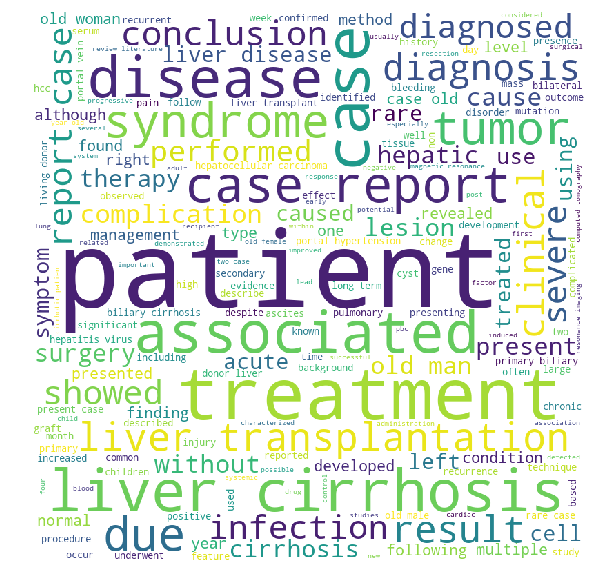

In [184]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

In [256]:
tokenizer.word_counts['patients']

1048

## Compare Group Frequencies

In [199]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

In [211]:
count_vec = CountVectorizer()
dfm_data = vec.fit_transform(clean_data_tr.txt)

dfm = pd.DataFrame(dfm_data.toarray(), columns = vec.get_feature_names())

In [213]:
dfm.head()

,03,05,08,0_date_,0_date__lgnum_,10,11,11_date_,11_date_ng,12,...,zoonosis,zoonotic,zoster,zosteriform,zr,zurich,zygoma,zygomatic,zygomycetes,zygomycosis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
tokenizer.word_counts['zoonotic']

1

In [215]:
dfm.shape

(1289, 14084)

In [216]:
from sklearn import feature_selection

In [223]:
(chi_features_stat, chi_features_p) = feature_selection.chi2(dfm_data, clean_data.label)

In [224]:
np.where(dfm.columns == "liver")

(array([7452], dtype=int64),)

In [225]:
chi_features_stat[7452]

1605.464602832808

In [226]:
chi_features_p[7452]

0.0

In [234]:
keyness_df = pd.DataFrame(dfm.columns,
                          columns=['term'])
keyness_df['chi2_stat'] = chi_features_stat
keyness_df['chi2_p'] = chi_features_p

In [241]:
keyness_df.sort_values(by='chi2_stat', ascending=False).head(19)

,term,chi2_stat,chi2_p
7452,liver,1605.464603,0.000000e+00
2337,cirrhosis,1031.374837,2.720266e-226
5848,hepatitis,377.672972,3.995727e-84
13103,transplantation,352.491367,1.215107e-78
9937,portal,330.205676,8.669436e-74
5841,hepatic,308.648696,4.301295e-69
1600,biliary,210.868673,8.878669e-48
3799,donor,181.208454,2.639797e-41
13675,vein,165.499697,7.114644e-38
9464,pbc,150.686767,1.227018e-34


In [254]:

keyness_df[
    [t in ("nerve", "melanoma", "sarcoma") for t in keyness_df.term]].sort_values(by = 'chi2_stat')

,term,chi2_stat,chi2_p
7852,melanoma,25.018786,5.677444e-07
11373,sarcoma,26.744220,2.322454e-07
8548,nerve,73.101548,1.231479e-17


In [265]:
case_rows = [l == 1 for l in clean_data.label]

np.mean(dfm.nerve[case_rows])

0.0016750418760469012

In [266]:
np.mean(dfm.nerve[np.logical_not(case_rows)])

0.12716763005780346

## Deep Learning

In [268]:
from sklearn.model_selection import train_test_split

In [269]:
train_test_split?

In [283]:
(X_train, X_test, y_train, y_test) =  train_test_split(
    clean_data.txt, clean_data.label, 
                            test_size = .3, stratify = clean_data.label)

In [295]:
seq_train = tokenizer.texts_to_sequences(X_train.values)
seq_test = tokenizer.texts_to_sequences(X_test.values)

In [301]:
maxlen = np.max(word_counts) + 1

In [302]:
maxlen

554

In [303]:
X_train_pad = keras.preprocessing.sequence.pad_sequences(
    seq_train, maxlen=maxlen)
X_test_pad = keras.preprocessing.sequence.pad_sequences(
    seq_test, maxlen=maxlen)

In [304]:
X_train_pad.shape

(902, 554)